In [37]:
from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
                                      AcrobotPlant, AcrobotState, AcrobotParams)
from pydrake.all import Linearize, LinearQuadraticRegulator, SymbolicVectorSystem, Variable, Saturation, \
WrapToSystem, Simulator, Polynomial

from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.primitives import LogVectorOutput

from IPython.display import SVG, display
import pydot
import numpy as np
import math
import control

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pydrake.forwarddiff as pf
import time

from IPython.display import display, Math, Markdown
from pydrake.examples.pendulum import PendulumPlant
from pydrake.examples.acrobot import AcrobotPlant
from pydrake.all import MultibodyPlant, Parser, SinCos, MakeVectorVariable, ToLatex, Substitute, Box
from underactuated import FindResource
from underactuated.scenarios import AddShape

from pydrake.all import (Jacobian, MathematicalProgram, Polynomial,
                         RegionOfAttraction, RegionOfAttractionOptions, Solve,
                         SymbolicVectorSystem, ToLatex, Variable, Variables,
                         plot_sublevelset_expression, AddMultibodyPlantSceneGraph, SolverOptions, 
                         CommonSolverOption)

from pydrake.solvers.mosek import MosekSolver
import sympy as sp
from sympy.physics.vector import dynamicsymbols as dynamicsymbols

from pydrake.all import (LinearQuadraticRegulator, MathematicalProgram, Variables,
                         Solve, RealContinuousLyapunovEquation)

In [38]:
from pydrake.examples.pendulum import PendulumParams
from pydrake.systems.controllers import LinearQuadraticRegulator
import scipy

In [39]:
p = PendulumParams()

In [40]:
b = p.damping()
m = p.mass()
l = p.length()
g = p.gravity()

In [41]:
A = np.zeros([3, 3])
A[0,2] = -1
A[2,0] = -g/l
A[2,2] = -b/(m*l**2)

B = np.zeros([3, 1])
B[2,0] = 1

F = np.zeros([1, 3])
F[0, 1] = -2

In [42]:
Q = np.diag([10, 10, 1])
R = [1]

In [43]:
controller = LinearQuadraticRegulator(A=A, B=B, Q=Q, R=R, F=F)

In [44]:
controller

(array([[-39.4932081 ,   0.        ,   8.55245308]]),
 array([[185.76196307,   0.        , -39.4932081 ],
        [  0.        ,   0.        ,   0.        ],
        [-39.4932081 ,   0.        ,   8.55245308]]))

In [45]:
A_cloop = A - B@controller[0]

In [46]:
A_cloop

array([[ 0.        ,  0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ],
       [19.8732081 ,  0.        , -8.95245308]])

In [47]:
P_proj = scipy.linalg.null_space(F)

In [48]:
P_proj.T@P_proj

array([[1., 0.],
       [0., 1.]])

In [50]:
P = RealContinuousLyapunovEquation(P_proj.T@A_cloop@P_proj, np.eye(2))

In [51]:
P = P_proj@P@P_proj.T

In [52]:
P

array([[ 1.39102074,  0.        , -0.0251595 ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.0251595 ,  0.        ,  0.05866096]])

In [53]:
np.linalg.eigvals(P)

array([1.39149567, 0.05818603, 0.        ])

In [54]:
K = controller[0][0]
#K = np.array([10.74101105,  0.        ,  2.42596626])

In [64]:
prog = MathematicalProgram()

x = prog.NewIndeterminates(3, 'x')
x0 = np.array([0, -1, 0])

f1 = x[1]*x[2]
f2 = -x[0]*x[2]
f3 = (-b/(m*l**2))*x[2] - (g/l)*x[0] - K@(x-x0)

rho = prog.NewContinuousVariables(1, 'rho')[0]

f = np.hstack([f1, f2, f3])

V = (x-x0).T@controller[1]@(x-x0) + (x-x0).dot(x-x0)
#V = (x-x0).dot(x-x0)
Vdot = V.Jacobian(x).dot(f)

V = Polynomial(V)
Vdot = Polynomial(Vdot)

lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0]
lambda_s = prog.NewFreePolynomial(Variables(x), 2)

trig = Polynomial(x[0]**2 + x[1]**2 - 1)

prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig)

prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

/tmp/ipykernel_7975/2003570210.py:8: RuntimeWarning: invalid value encountered in subtract
  f3 = (-b/(m*l**2))*x[2] - (g/l)*x[0] - K@(x-x0)
/tmp/ipykernel_7975/2003570210.py:8: RuntimeWarning: invalid value encountered in matmul
  f3 = (-b/(m*l**2))*x[2] - (g/l)*x[0] - K@(x-x0)
/tmp/ipykernel_7975/2003570210.py:14: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@controller[1]@(x-x0) + (x-x0).dot(x-x0)
/tmp/ipykernel_7975/2003570210.py:14: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@controller[1]@(x-x0) + (x-x0).dot(x-x0)
/tmp/ipykernel_7975/2003570210.py:26: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig)
/tmp/ipykernel_7975/2003570210.py:26: RuntimeWarning: invalid value encountered in matmul
  prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig)


In [63]:
prog = MathematicalProgram()

x = prog.NewIndeterminates(3, 'x')

V = (x-x0).T@P@(x-x0) + (x-x0).dot(x-x0)
V = Polynomial(V)

trig = Polynomial(x[0]**2 + x[1]**2 - 1)
lambda_s = prog.NewFreePolynomial(Variables(x), 2)

eps = 1e-5

prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0))+ lambda_s*trig)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

/tmp/ipykernel_7975/4201798018.py:5: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@P@(x-x0) + (x-x0).dot(x-x0)
/tmp/ipykernel_7975/4201798018.py:5: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@P@(x-x0) + (x-x0).dot(x-x0)
/tmp/ipykernel_7975/4201798018.py:13: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0))+ lambda_s*trig)


In [65]:
result.GetSolution(rho)

3.481745484340739

In [22]:
k = result.get_solver_details().solution_status
k

1

In [23]:
V

<Polynomial "8.5524530822923381*x(2)^2 + -78.9864161906455*x(0) * x(2) + 185.76196306800884*x(0)^2">

/tmp/ipykernel_4661/3672201516.py:11: RuntimeWarning: invalid value encountered in sin
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
/tmp/ipykernel_4661/3672201516.py:11: RuntimeWarning: invalid value encountered in cos
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
/tmp/ipykernel_4661/3672201516.py:11: RuntimeWarning: invalid value encountered in multiply
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td


<IPython.core.display.Javascript object>


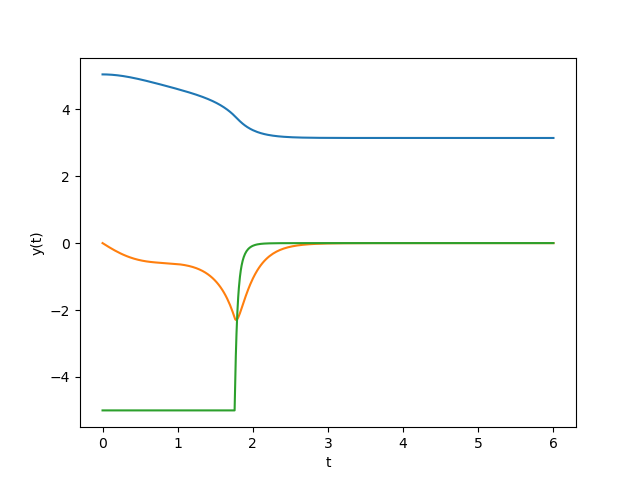

In [196]:
#before moving further, confirm that implicitly found dynamics work in simulation
def UprightState():
    return np.array([np.pi, 0])

t = Variable("t")
td = Variable("td")
garbage = Variable("garbage")

K = controller[0][0]
x = np.hstack([t, td])
u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
u_old = -u_old

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=[u_old])

# dv_0 = td
# dv_1 = (-b*td - mass*gravity*length*pydrake.forwarddiff.sin(t) + u)/(mass*length**2)

# x_dot = np.array([dv_0, dv_1])

# continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)

def acrobot_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())
    
    saturation = builder.AddSystem(Saturation(min_value=[-5], max_value=[5]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    logger2 = LogVectorOutput(saturation.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 6 
    for i in range(1):
        context.SetTime(0.)
        np.random.seed(10000)
#         context.SetContinuousState(np.append(UprightState(), 0) -
#                                  1.4* np.random.randn(3,))
        context.SetContinuousState(np.array([np.pi+1.9, 0, 0]))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())\
        
        log2 = logger2.FindLog(context)
        plt.plot(log2.sample_times(), log2.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [73]:
K

array([-39.4932081 ,   0.        ,   8.55245308])

Same things implicitly
$E\dot{x} = Ax + Bu$ and
$Fx = 0$

In [66]:
A = np.zeros([3, 3])
A[0,2] = -1
A[2,0] = -m*g*l
A[2,2] = -b

E = np.eye(3)
E[2,2] = m*l**2

B = np.zeros([3, 1])
B[2,0] = 1

F = np.zeros([1, 3])
F[0, 1] = -2

Find matrix $P_{proj}$ such that its rows form an orthonormal basis for the kernel of F

In [67]:
P_proj = scipy.linalg.null_space(F)
P_proj = P_proj.T

In [68]:
Q = np.diag([10, 10, 1])
R = [1]

In [69]:
X, L, G = control.care(P_proj@A@P_proj.T, P_proj@B, P_proj@Q@P_proj.T, R, E = P_proj@E@P_proj.T)

In [70]:
X = P_proj.T@X@P_proj

In [71]:
controller = B.T@X@E

In [72]:
controller

array([[-10.74101105,   0.        ,   2.42596626]])

/tmp/ipykernel_7975/218991154.py:11: RuntimeWarning: invalid value encountered in sin
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
/tmp/ipykernel_7975/218991154.py:11: RuntimeWarning: invalid value encountered in cos
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
/tmp/ipykernel_7975/218991154.py:11: RuntimeWarning: invalid value encountered in multiply
  u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td


<IPython.core.display.Javascript object>


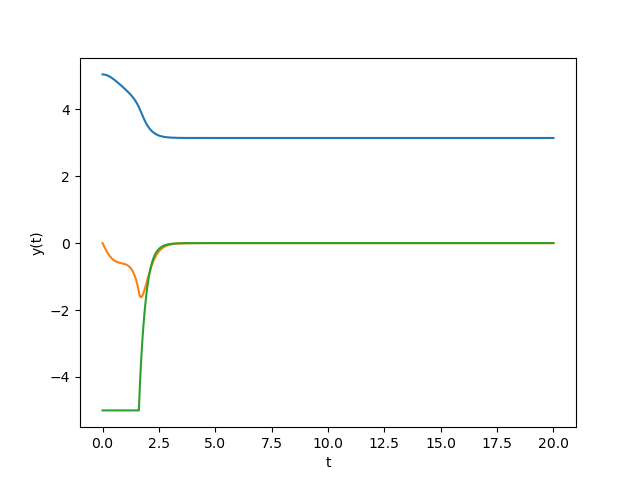

In [73]:
#before moving further, confirm that implicitly found dynamics work in simulation
def UprightState():
    return np.array([np.pi, 0])

t = Variable("t")
td = Variable("td")
garbage = Variable("garbage")

K = controller[0]
x = np.hstack([t, td])
u_old = K[0]*np.sin(t) + K[1]*np.cos(t) + K[2]*td
u_old = -u_old

own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=[u_old])

# dv_0 = td
# dv_1 = (-b*td - mass*gravity*length*pydrake.forwarddiff.sin(t) + u)/(mass*length**2)

# x_dot = np.array([dv_0, dv_1])

# continuous_vector_system = SymbolicVectorSystem(state=x, dynamics=x_dot, output=x)

def acrobot_balancing_example():

    builder = DiagramBuilder()
    pendulum = builder.AddSystem(PendulumPlant())
    
    saturation = builder.AddSystem(Saturation(min_value=[-5], max_value=[5]))
    builder.Connect(saturation.get_output_port(0), pendulum.get_input_port(0))
    wrapangles = WrapToSystem(2)
    wrapangles.set_interval(0, 0, 2. * np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(pendulum.get_output_port(0), wrapto.get_input_port(0))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))
    
    logger = LogVectorOutput(wrapto.get_output_port(0), builder)
    logger2 = LogVectorOutput(saturation.get_output_port(0), builder)
    
    diagram = builder.Build()
    
    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()

    # Simulate
    simulator.set_target_realtime_rate(0.0)
    duration = 20
    for i in range(1):
        context.SetTime(0.)
        np.random.seed(10000)
#         context.SetContinuousState(np.append(UprightState(), 0) -
#                                  1.4* np.random.randn(3,))
        context.SetContinuousState(np.array([np.pi+1.9, 0, 0]))
        simulator.Initialize()
        simulator.AdvanceTo(duration)
        
        log = logger.FindLog(context)
        plt.figure()
        plt.plot(log.sample_times(), log.data().transpose())\
        
        log2 = logger2.FindLog(context)
        plt.plot(log2.sample_times(), log2.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)');
    

acrobot_balancing_example()

In [74]:
A_cloop = A - B@controller

In [75]:
P = control.lyap((P_proj@A_cloop@P_proj.T).T, np.eye(2), E = (P_proj@E@P_proj.T).T)

In [76]:
P = P_proj.T@P@P_proj

In [77]:
P

array([[ 1.42110175,  0.        , -0.08567496],
       [ 0.        ,  0.        ,  0.        ],
       [-0.08567496,  0.        ,  0.82569391]])

In [78]:
np.linalg.eigvals(P)

array([1.43318457, 0.81361109, 0.        ])

In [79]:
X

array([[ 15.23206699,   0.        , -10.74101105],
       [  0.        ,   0.        ,   0.        ],
       [-10.74101105,   0.        ,   9.70386502]])

In [82]:
prog = MathematicalProgram()

x = prog.NewIndeterminates(3, 'x')
x0 = np.array([0, -1, 0])
I = np.eye(3)

V = (x-x0).T@E.T@P@E@(x-x0) + (x-x0).T@E.T@I@E@(x-x0)
V = Polynomial(V)

trig = Polynomial(x[0]**2 + x[1]**2 - 1)
lambda_s = prog.NewFreePolynomial(Variables(x), 2)

prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

/tmp/ipykernel_7975/3075539789.py:7: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@E.T@P@E@(x-x0) + (x-x0).T@E.T@I@E@(x-x0)
/tmp/ipykernel_7975/3075539789.py:7: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@E.T@P@E@(x-x0) + (x-x0).T@E.T@I@E@(x-x0)
/tmp/ipykernel_7975/3075539789.py:13: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)


In [85]:
prog = MathematicalProgram()

x = prog.NewIndeterminates(3, 'x')
x0 = np.array([0, -1, 0])

f1 = x[1]*x[2]
f2 = -x[0]*x[2]
f3 = -b*x[2] - m*g*l*x[0] - K@(x-x0)

rho = prog.NewContinuousVariables(1, 'rho')[0]

f = np.hstack([f1, f2, f3])

V = (x-x0).T@E.T@(P+I)@E@(x-x0)
Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
#Vdot = (x-x0).T@A_cloop.T@P@E@(x-x0) + (x-x0).T@E.T@P@A_cloop@(x-x0)

V = Polynomial(V)
Vdot = Polynomial(Vdot)

lambda_ = prog.NewSosPolynomial(Variables(x), 2)[0]
lambda_s = prog.NewFreePolynomial(Variables(x), 2)

trig = Polynomial(x[0]**2 + x[1]**2 - 1)

# prog.AddSosConstraint(-Vdot - eps*Polynomial((x-x0)@(x-x0))+ lambda_*(V - rho) + lambda_s*(trig))
prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig)

prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

assert result.is_success()

/tmp/ipykernel_7975/3913101980.py:8: RuntimeWarning: invalid value encountered in subtract
  f3 = -b*x[2] - m*g*l*x[0] - K@(x-x0)
/tmp/ipykernel_7975/3913101980.py:8: RuntimeWarning: invalid value encountered in matmul
  f3 = -b*x[2] - m*g*l*x[0] - K@(x-x0)
/tmp/ipykernel_7975/3913101980.py:14: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@E.T@(P+I)@E@(x-x0)
/tmp/ipykernel_7975/3913101980.py:14: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@E.T@(P+I)@E@(x-x0)
/tmp/ipykernel_7975/3913101980.py:15: RuntimeWarning: invalid value encountered in matmul
  Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
/tmp/ipykernel_7975/3913101980.py:15: RuntimeWarning: invalid value encountered in subtract
  Vdot = f.T@(P+I)@E@(x-x0) + (x-x0).T@E.T@(P+I)@f
/tmp/ipykernel_7975/3913101980.py:27: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(Polynomial((x-x0)@(x-x0))*(V - rho) - lambda_*Vdot + lambda_s*trig)
/tmp/ipykernel_7975/3913

In [86]:
result.GetSolution(rho)

2.777367089869795

In [87]:
list(V.indeterminates())

[Variable('x(0)', Continuous),
 Variable('x(1)', Continuous),
 Variable('x(2)', Continuous)]

<IPython.core.display.Javascript object>


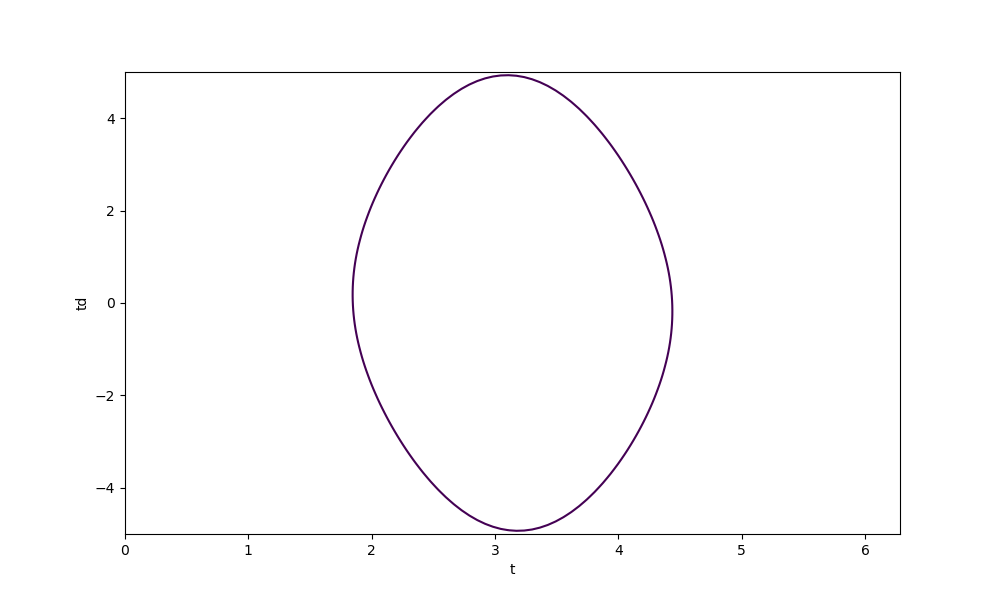

Text(0.5, 0, 't')

In [91]:
V_indeterminates = list(V.indeterminates())
# V_indeterminates

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
# img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

thetas = np.linspace(0, 2*np.pi, 100)
theta_ds = np.linspace(-5, 5, 100)
theta, theta_d = np.meshgrid(thetas, theta_ds)

Vplot = np.zeros_like(theta)

env = {}
for i in range(len(theta)):
    for j in range(len(theta[i])): 
        env[V_indeterminates[0]] = np.sin(theta[i, j])
        env[V_indeterminates[1]] = np.cos(theta[i, j])
        env[V_indeterminates[2]] = theta_d[i, j]
        Vplot[i, j] = V.Evaluate(env)

# Vplot_old = np.zeros_like(TRV1)
# env_old = {}
# for i in range(len(TRV1)):
#     for j in range(len(TRV1[i])): 
#         env_old[V_old_indeterminates[0]] = XRV1[i, j]
#         env_old[V_old_indeterminates[1]] = TRV1[i, j] - np.pi
#         env_old[V_old_indeterminates[2]] = 0
#         env_old[V_old_indeterminates[3]] = 0
#         Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(theta,theta_d, Vplot, levels=[2.77])
# ax.contour(TRV1,XRV1, Vplot_old, levels=[4005.9])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_ylabel("td")
ax.set_xlabel("t")

## For the Cartpole

In [108]:
mp = 1
mc = 10
l = 0.5
g = 9.8

In [109]:
E = np.eye(5)
E[3,3] = mc+mp
E[3,4] = -mp*l
E[4,3] = -mp*l
E[4,4] = mp*l**2

A = np.zeros([5,5])
A[0,3] = 1
A[1,4] = -1
A[4,1] = -mp*g*l

B = np.zeros([5,1])
B[3,0] = 1

F = np.zeros([1,5])
F[0,2] = -2

In [110]:
Q = np.diag([10, 10, 10, 1, 1])
R = [1]

In [111]:
P_proj = (scipy.linalg.null_space(F)).T

In [112]:
X, L, G = control.care(P_proj@A@P_proj.T, P_proj@B, P_proj@Q@P_proj.T, R, E = P_proj@E@P_proj.T)

In [113]:
P = P_proj.T@X@P_proj
K = B.T@P@E

In [114]:
K

array([[  -3.16227766, -254.15443856,    0.        ,   -9.76993902,
          55.1540753 ]])

In [119]:
prog = MathematicalProgram()
x = prog.NewIndeterminates(5, 'X')
x0 = np.array([0, 0, -1, 0, 0])

M = np.eye(5, dtype='object')
M[3,3] = mc+mp
M[3,4] = mp*l*x[2]
M[4,3] = mp*l*x[2]
M[4,4] = mp*l**2

lambda_s = prog.NewFreePolynomial(Variables(x), 2)

eps = 1e-5

trig = Polynomial(x[1]**2 + x[2]**2 - 1)
I = np.eye(5)
V = (x-x0).T@M.T@(P+I)@M@(x-x0)
V = Polynomial(V)

prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)

solver = MosekSolver()
result = solver.Solve(prog)

print(str(result.get_solver_details().solution_status))

assert result.is_success()

1


/tmp/ipykernel_7975/1702093163.py:17: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@M.T@(P+I)@M@(x-x0)
/tmp/ipykernel_7975/1702093163.py:17: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@M.T@(P+I)@M@(x-x0)
/tmp/ipykernel_7975/1702093163.py:20: RuntimeWarning: invalid value encountered in subtract
  prog.AddSosConstraint(V - eps*Polynomial((x-x0).dot(x-x0)) + lambda_s*trig)


In [127]:
prog = MathematicalProgram()
x = prog.NewIndeterminates(5, 'X')
x0 = np.array([0, 0, -1, 0, 0])
y = P_proj@x
y0 = P_proj@x0

M = np.eye(5, dtype='object')
M[3,3] = mc+mp
M[3,4] = mp*l*x[2]
M[4,3] = mp*l*x[2]
M[4,4] = mp*l**2

My = P_proj@M@P_proj.T

Mdot = np.eye(5, dtype='object')
Mdot[3,3] = 0
Mdot[3,4] = -mp*l*x[1]*x[4]
Mdot[4,3] = -mp*l*x[1]*x[4]
Mdot[4,4] = 0

Mdoty = P_proj@M@P_proj.T

f = np.zeros([5,1], dtype='object')
f[0,0] = x[3]
f[1,0] = x[2]*x[4]
f[2,0] = -x[1]*x[4]
f[3,0] = mp*l*x[4]**2*x[1] - (K@(x-x0))[0]
f[4,0] = -mp*g*l*x[1]

fy = P_proj@f
P_corr = P + I

V = (x-x0).T@M.T@P_corr@M@(x-x0)
Vdot = f.T@P_corr@M@(x-x0) + (x-x0).T@Mdot.T@P_corr@M@(x-x0) \
        + (x-x0).T@M.T@P_corr@Mdot@(x-x0) + (x-x0).T@M.T@P_corr@f

# V = y.T@My.T@X@My@y
# Vdot = fy.T@X@My@y + y.T@Mdoty.T@X@My@y + y.T@My.T@X@Mdoty@y + y.T@My.T@X@fy

V = Polynomial(V)
Vdot = Polynomial(Vdot[0])

trig = Polynomial(x[1]**2 + x[2]**2 - 1)

lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 4)
lambda_s = prog.NewFreePolynomial(Variables(x), 6)

d = 2

rho = prog.NewContinuousVariables(1, 'rho')[0]
prog.AddSosConstraint(Polynomial(((x-x0).dot(x-x0))**d)*(V - rho) - lambda_*Vdot + lambda_s*trig)

# lambda_, lambda_Q = prog.NewSosPolynomial(Variables(x), 6)

# d = 4
# rho = prog.NewContinuousVariables(1, 'rho')[0]
# prog.AddSosConstraint(Polynomial(((y-y0).dot(y-y0))**d)*(V - rho) - lambda_*Vdot)

prog.AddCost(-rho)

solver = MosekSolver()
result = solver.Solve(prog)

print(str(result.get_solver_details().solution_status))

assert result.is_success()

/tmp/ipykernel_7975/307128659.py:4: RuntimeWarning: invalid value encountered in matmul
  y = P_proj@x
/tmp/ipykernel_7975/307128659.py:13: RuntimeWarning: invalid value encountered in matmul
  My = P_proj@M@P_proj.T
/tmp/ipykernel_7975/307128659.py:21: RuntimeWarning: invalid value encountered in matmul
  Mdoty = P_proj@M@P_proj.T
/tmp/ipykernel_7975/307128659.py:27: RuntimeWarning: invalid value encountered in subtract
  f[3,0] = mp*l*x[4]**2*x[1] - (K@(x-x0))[0]
/tmp/ipykernel_7975/307128659.py:27: RuntimeWarning: invalid value encountered in matmul
  f[3,0] = mp*l*x[4]**2*x[1] - (K@(x-x0))[0]
/tmp/ipykernel_7975/307128659.py:30: RuntimeWarning: invalid value encountered in matmul
  fy = P_proj@f
/tmp/ipykernel_7975/307128659.py:33: RuntimeWarning: invalid value encountered in subtract
  V = (x-x0).T@M.T@P_corr@M@(x-x0)
/tmp/ipykernel_7975/307128659.py:33: RuntimeWarning: invalid value encountered in matmul
  V = (x-x0).T@M.T@P_corr@M@(x-x0)
/tmp/ipykernel_7975/307128659.py:34: Runt

1


In [128]:
result.GetSolution(rho)

0.05956212721056036

In [177]:
result.GetSolution(rho)

1.4794323390240265e-05

In [126]:
V.TotalDegree()

4

In [175]:
y0

array([0., 0., 0., 0.])

In [218]:
list(V.indeterminates())

[Variable('X(0)', Continuous),
 Variable('X(1)', Continuous),
 Variable('X(2)', Continuous),
 Variable('X(3)', Continuous),
 Variable('X(4)', Continuous)]

<IPython.core.display.Javascript object>


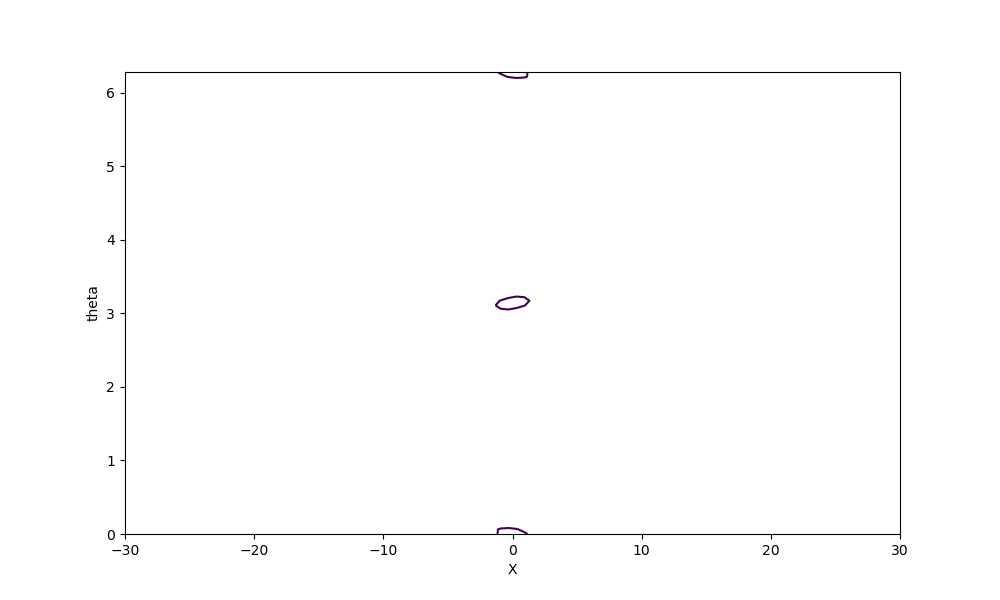

Text(0.5, 0, 'X')

In [131]:
V_indeterminates = list(V.indeterminates())
# V_indeterminates

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# img = ax.scatter(TR1[success_indices], XR1[success_indices], alpha=0.2)
# img = ax.scatter(TR1_old[success_indices_old], XR1_old[success_indices_old], alpha=0.02)

TRV = np.linspace(0, 2*np.pi, 100)
XRV = np.linspace(-30, 30, 100)
TRV1, XRV1 = np.meshgrid(TRV, XRV)

Vplot = np.zeros_like(TRV1)

env = {}
for i in range(len(TRV1)):
    for j in range(len(TRV1[i])): 
        env[V_indeterminates[0]] = XRV1[i, j]
        env[V_indeterminates[1]] = np.sin(TRV1[i, j])
        env[V_indeterminates[2]] = np.cos(TRV1[i, j])
        env[V_indeterminates[3]] = 0
        env[V_indeterminates[4]] = 0
        Vplot[i, j] = V.Evaluate(env)

# Vplot_old = np.zeros_like(TRV1)
# env_old = {}
# for i in range(len(TRV1)):
#     for j in range(len(TRV1[i])): 
#         env_old[V_old_indeterminates[0]] = XRV1[i, j]
#         env_old[V_old_indeterminates[1]] = TRV1[i, j] - np.pi
#         env_old[V_old_indeterminates[2]] = 0
#         env_old[V_old_indeterminates[3]] = 0
#         Vplot_old[i, j] = V_old.Evaluate(env_old)
        
ax.contour(XRV1,TRV1, Vplot, levels=[50])
# ax.contour(TRV1,XRV1, Vplot_old, levels=[4005.9])
# ax.set_xlim(0, 2*np.pi)
# ax.set_ylim(-100, 100)
ax.set_ylabel("theta")
ax.set_xlabel("X")

HERE
[[1.      0.00981 0.1     0.     ]
 [0.      1.21582 0.      0.1    ]
 [0.      0.0981  1.      0.     ]
 [0.      2.1582  0.      1.     ]]
[[0.001]
 [0.002]
 [0.01 ]
 [0.02 ]]
[40.   3.2  0.   0. ]


/tmp/ipykernel_4048/2888823348.py:50: RuntimeWarning: invalid value encountered in multiply
  u = -K[0]*x[0] - K[1]*np.sin(x[1]) - K[3]*x[2] - K[4]*x[3]
/tmp/ipykernel_4048/2888823348.py:50: RuntimeWarning: invalid value encountered in sin
  u = -K[0]*x[0] - K[1]*np.sin(x[1]) - K[3]*x[2] - K[4]*x[3]


<IPython.core.display.Javascript object>


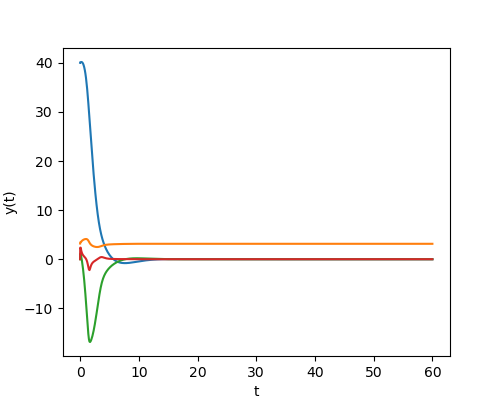

In [149]:
def cartpole_balancing_example():
    def UprightState():
        state = (0, np.pi, 0, 0)
        return state

    def Linearized_Matrices(plant):
        print('HERE')
        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])
        plant.SetPositionsAndVelocities(context, UprightState())

        linearized_plant = Linearize(
            plant,
            context,
            input_port_index=plant.get_actuation_input_port().get_index(), output_port_index=plant.get_state_output_port().get_index())
        print(linearized_plant.A())
        print(linearized_plant.B())

    def BalancingLQR(plant):
        # Design an LQR controller for stabilizing the CartPole around the upright.
        # Returns a (static) AffineSystem that implements the controller (in
        # the original CartPole coordinates).

        context = plant.CreateDefaultContext()
        plant.get_actuation_input_port().FixValue(context, [0])

        plant.SetPositionsAndVelocities(context, UprightState())

        Q = np.diag((10., 10., 1., 1.))
        R = np.array([1])

        # MultibodyPlant has many (optional) input ports, so we must pass the
        # input_port_index to LQR.
        return LinearQuadraticRegulator(
            plant,
            context,
            Q,
            R,
            input_port_index=plant.get_actuation_input_port().get_index())
    
    x = Variable("x")
    theta = Variable("t")
    xdot = Variable("\dot{x}")
    thetadot = Variable("\dot{t}")
    u_symbolic = Variable("u")
    garbage = Variable("garbage")

    x = np.hstack([x, theta, xdot, thetadot])
    K = np.array([  -3.16227766, -254.15443856,    0,   -9.76993902, 55.1540753 ])
    u = -K[0]*x[0] - K[1]*np.sin(x[1]) - K[3]*x[2] - K[4]*x[3]
    own_controller = SymbolicVectorSystem(state=[garbage], input=x, dynamics=np.array([0]), output=[u])
    
    
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.1)
    file_name = FindResource("models/cartpole.urdf")
    Parser(plant).AddModelFromFile(file_name)
    plant.Finalize()
#     print('HERE')
    Linearized_Matrices(plant)
    
    wrapangles = WrapToSystem(4)
    wrapangles.set_interval(1, 0, 2*np.pi)
    wrapto = builder.AddSystem(wrapangles)
    builder.Connect(plant.get_state_output_port(), wrapto.get_input_port())
    
    #controller = builder.AddSystem(BalancingLQR(plant))
    controller = builder.AddSystem(own_controller)
    builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), plant.get_actuation_input_port())
    
    logger = LogVectorOutput(wrapto.get_output_port(), builder)

#     # Setup visualization
#     meshcat.Delete()
#     meshcat.Set2dRenderMode(xmin=-2.5, xmax=2.5, ymin=-1.0, ymax=2.5)
#     MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    plant_context = plant.GetMyMutableContextFromRoot(context)

    # Simulate
    simulator.set_target_realtime_rate(0)
    duration = 60
    for i in range(1):
        context.SetTime(0.)
    #     plant.SetPositionsAndVelocities(
    #         plant_context,
    #         UprightState() + 0.9 * np.random.randn(4,))
        trial = np.append(UprightState(), 0) - 0.1*np.random.randn(5)
        trial = np.array([40, 3.2, 0, 0])
        print(trial)
        plant.SetPositionsAndVelocities(
            plant_context, trial)
        simulator.Initialize()
        simulator.AdvanceTo(duration)

        log = logger.FindLog(context)

        end_state = log.data()[:, -1]
        diff = np.abs(end_state - UprightState())
        plt.figure(figsize=(5, 4))
        plt.plot(log.sample_times(), log.data().transpose())
        plt.xlabel('t')
        plt.ylabel('y(t)')

#np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})
cartpole_balancing_example()